In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

from src.micrograd import Tensor, TensorLayer, TensorMLP

from sklearn.datasets import make_moons, make_blobs

from functools import reduce

%matplotlib inline

In [8]:
seed = 1996
np.random.seed(1996)
random.seed(1996)

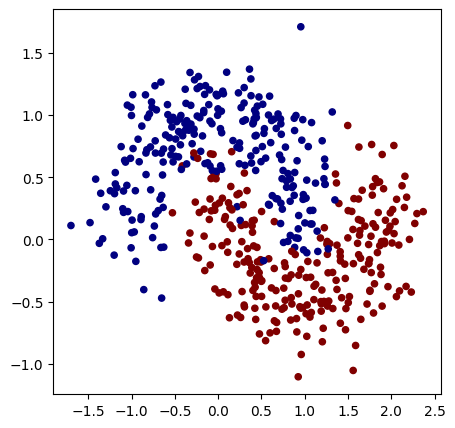

In [9]:
X, y = make_moons(n_samples=500, noise=0.25, random_state=seed)
# X, y = make_blobs(n_samples=250, n_features=2, centers=2, cluster_std=2)
y = y*2 - 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [10]:
model = TensorMLP.from_layers([
    TensorLayer(2, 16, activation='Relu'), 
    TensorLayer(16, 16, activation='Relu'), 
    TensorLayer(16, 1, activation='Linear')
])

# model = TensorMLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [ReluLayer(2 -> 16), ReluLayer(16 -> 16), LinearLayer(16 -> 1)]
number of parameters 6


In [11]:
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = list(map(Tensor, Xb))

    scores = list(map(model, inputs))
    
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    alpha = 1e-4
    reg_loss = alpha * sum([(p * p).sum() for p in model.parameters()])
    total_loss = data_loss + reg_loss
    
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, reg_loss, sum(accuracy) / len(accuracy)

In [12]:
# optimization
for k in range(100):
    total_loss, reg_loss, acc = loss()
    
    model.zero_grad()
    total_loss.backward()
    
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"epoch[{k}] lr {learning_rate:.2f} | loss {total_loss.data.item():.2f} | accuracy {acc.item()}")

epoch[0] lr 1.00 | loss 0.88 | accuracy 0.466
epoch[10] lr 0.91 | loss 0.29 | accuracy 0.872
epoch[20] lr 0.82 | loss 0.25 | accuracy 0.888
epoch[30] lr 0.73 | loss 0.21 | accuracy 0.918
epoch[40] lr 0.64 | loss 0.18 | accuracy 0.932
epoch[50] lr 0.55 | loss 0.16 | accuracy 0.942
epoch[60] lr 0.46 | loss 0.14 | accuracy 0.952
epoch[70] lr 0.37 | loss 0.14 | accuracy 0.95
epoch[80] lr 0.28 | loss 0.14 | accuracy 0.944
epoch[90] lr 0.19 | loss 0.13 | accuracy 0.946


(-2.105724179977916, 2.644275820022084)

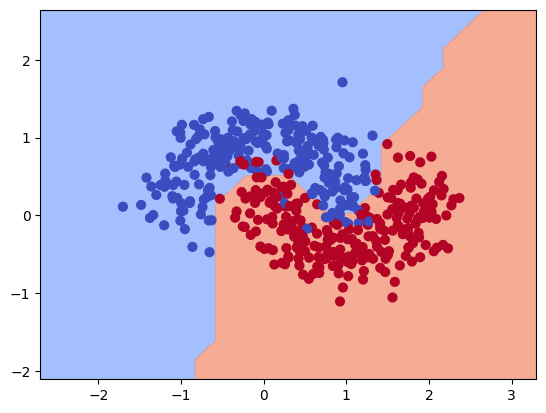

In [13]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = list(map(Tensor, Xmesh))
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())